# Applied Data Science Capstone Project
## Jeremy Ross

## Introduction  

This exercise will seek to show a good location to open up a Japanese restaurant in Manhattan. This would be value to anyone looking to open up a Japanese restaurant based on certain criteria that is further discussed in the data section.

### Data  
The key datapoints that are needed for this exercise are
- Number of any restaurant in each neighborhood
- Number of Japenese restuarants in each neighbord
- Adjusted Gross Income (AGI)
- Zipcodes
- Lattitude/Longitude (ie location of neighborhoods and restaurants)

We will be leveraging the following sources for data  
- Forusqure API
- source of file from 2014 NYU dataset that has coordinates of each New York City neighborhood
- IRS data to get AGI by zip: https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi
- geopy: this will enable mapping coordinates to zip code

### Methodology
As mentioned above, we need to capture the following
- Frequency of types of restaurants in each neighborhood
- Number of any restaurant in each neighborhood
- Number of Japenese restuarants in each neighbord
- Adjusted Gross Income (AGI). Although we do can do this at various income levels, we are looking only at areas where the AGI is 75k+

In addtion, we will assess frequency of restaurants/top restaurants in each neighborhood


#### Number of restaurants in each neighborhood

In [70]:
import pandas as pd
import json
import numpy as np
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [71]:
#source of file from 2014 NYU dataset
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# create the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [72]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [73]:
# Since our analysis is just going to look at manhattan, let's restirct this to manhattan

#Focus Just On Manhattan
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [74]:
# Using Foursquare API
CLIENT_ID = 'JXMYEXBEH20DRGHDGBQ5DNU2C53DLGT1N0EQFKZCCSOEC5WX' # your Foursquare ID
CLIENT_SECRET = 'DNYNA4TLDWCGNERWGIEMSKT5IOQ1VJQB2OXQ2SFQY1VDNFYV' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
LIMIT = 2000

Your credentails:
CLIENT_ID: JXMYEXBEH20DRGHDGBQ5DNU2C53DLGT1N0EQFKZCCSOEC5WX
CLIENT_SECRET:DNYNA4TLDWCGNERWGIEMSKT5IOQ1VJQB2OXQ2SFQY1VDNFYV


In [75]:
# This will ristrict our search to just restuarnts and ensure we are not pulling in other types of business
search_query = 'Restaurant'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude',
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [76]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [77]:
print(manhattan_venues.shape)
manhattan_venues.head()

(2774, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
2,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
3,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
4,Marble Hill,40.876551,-73.91066,Subway Sandwiches,40.874667,-73.909586,Sandwich Place


In [78]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,26,26,26,26,26,26
Carnegie Hill,69,69,69,69,69,69
Central Harlem,44,44,44,44,44,44
Chelsea,79,79,79,79,79,79
Chinatown,100,100,100,100,100,100
Civic Center,81,81,81,81,81,81
Clinton,100,100,100,100,100,100
East Harlem,52,52,52,52,52,52
East Village,100,100,100,100,100,100


In [79]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 122 uniques categories.


In [80]:

# one hot encoding
venues_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
venues_onehot.shape

(2774, 123)

In [82]:
venues_grouped = venues_onehot.groupby('Neighborhood').sum().reset_index()
venues_grouped

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Battery Park City,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Carnegie Hill,0,1,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,2,0
2,Central Harlem,3,2,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,Chelsea,0,5,0,0,1,0,0,0,2,...,2,0,0,0,0,0,1,0,1,0
4,Chinatown,0,3,0,0,2,1,1,0,1,...,1,0,0,0,0,0,2,0,6,0
5,Civic Center,0,5,0,0,2,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
6,Clinton,0,8,0,0,1,0,0,0,1,...,4,0,0,0,0,0,1,0,0,0
7,East Harlem,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
8,East Village,0,3,1,1,1,0,0,0,3,...,1,0,0,0,1,1,5,0,6,1
9,Financial District,0,6,0,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,0,0


In [83]:
num_top_venues = 10

for hood in venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                venue  freq
0         Pizza Place   4.0
1  Italian Restaurant   3.0
2        Burger Joint   2.0
3          Food Court   2.0
4  Mexican Restaurant   2.0
5  Chinese Restaurant   2.0
6      Sandwich Place   2.0
7                Café   1.0
8          Donut Shop   1.0
9          Food Truck   1.0


----Carnegie Hill----
                 venue  freq
0          Pizza Place   8.0
1               Bakery   6.0
2                 Café   6.0
3     Sushi Restaurant   5.0
4   Italian Restaurant   4.0
5    French Restaurant   3.0
6  Japanese Restaurant   3.0
7   Mexican Restaurant   3.0
8           Food Truck   2.0
9           Restaurant   2.0


----Central Harlem----
                             venue  freq
0              Fried Chicken Joint   4.0
1                    Deli / Bodega   4.0
2               African Restaurant   3.0
3               Chinese Restaurant   3.0
4                       Restaurant   3.0
5  Southern / Soul Food Restaurant   3.0
6          

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_sorted.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Pizza Place,Italian Restaurant,Mexican Restaurant,Burger Joint,Sandwich Place,Chinese Restaurant,Food Court,Donut Shop,Seafood Restaurant,Food Truck
1,Carnegie Hill,Pizza Place,Bakery,Café,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,French Restaurant,Mexican Restaurant,Vietnamese Restaurant,Food Truck
2,Central Harlem,Fried Chicken Joint,Deli / Bodega,African Restaurant,Pizza Place,Restaurant,Chinese Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,French Restaurant,Caribbean Restaurant
3,Chelsea,American Restaurant,Italian Restaurant,French Restaurant,Café,Japanese Restaurant,Tapas Restaurant,Sandwich Place,Seafood Restaurant,Mexican Restaurant,Bakery
4,Chinatown,Chinese Restaurant,Bakery,Vietnamese Restaurant,Malay Restaurant,Dumpling Restaurant,Hotpot Restaurant,Mexican Restaurant,Noodle House,Dim Sum Restaurant,American Restaurant


In [86]:
venues_grouped.columns.values.tolist()

['Neighborhood',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Belgian Restaurant',
 'Bistro',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Buffet',
 'Burger Joint',
 'Burrito Place',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Creperie',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Deli / Bodega',
 'Dim Sum Restaurant',
 'Diner',
 'Donut Shop',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'Food',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Gastropub',
 'German Restaurant',
 'Gluten-fr

#### Number of Japanese restaurants and total restaurants in each neighborhood

In [87]:
df_pivot = manhattan_venues.pivot_table(index='Neighborhood', 
                                        columns='Venue Category', 
                                        aggfunc='size',
                                        fill_value=0)
df_pivot.head()

Venue Category,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Battery Park City,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Carnegie Hill,0,1,0,1,0,0,0,0,1,6,...,1,0,0,1,0,0,0,0,2,0
Central Harlem,3,2,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
Chelsea,0,5,0,0,1,0,0,0,2,3,...,2,0,0,0,0,0,1,0,1,0
Chinatown,0,3,0,0,2,1,1,0,1,8,...,1,0,0,0,0,0,2,0,6,0


In [88]:
# The following will be considered 'Japanese restaurants'
# Japanese Curry Restaurant
# Japanese Restaurant
# Soba Restaurant
# Sushi Restaurant

df_pivot_japanese = df_pivot[['Japanese Curry Restaurant','Japanese Restaurant','Soba Restaurant','Sushi Restaurant']]
total_japanese_restaurants= df_pivot_japanese['Japanese Curry Restaurant']+df_pivot_japanese['Japanese Restaurant']+df_pivot_japanese['Soba Restaurant']+df_pivot_japanese['Sushi Restaurant']
df_pivot_japanese['Total Japanese Restaurants']=total_japanese_restaurants

df_pivot_japanese.head(15)

C:\Users\Jeremy_Freelance\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Venue Category,Japanese Curry Restaurant,Japanese Restaurant,Soba Restaurant,Sushi Restaurant,Total Japanese Restaurants
Neighborhood,,,,,
Battery Park City,0,0,0,0,0
Carnegie Hill,0,3,0,5,8
Central Harlem,0,0,0,0,0
Chelsea,0,3,0,2,5
Chinatown,0,1,0,1,2
Civic Center,0,1,0,3,4
Clinton,0,1,0,1,2
East Harlem,0,0,0,0,0
East Village,1,6,0,1,8


In [89]:
df_pivot_japanese.reset_index(inplace = True)
df_pivot.reset_index(inplace = True)

df_pivot_total = manhattan_venues.pivot_table(index='Neighborhood', 
                                        aggfunc='size',
                                        fill_value=0)
df_pivot_total.head()
df_total = pd.DataFrame(df_pivot_total)
df_total.reset_index(inplace=True)
df_total.columns =['Neighborhood', 'Total Restaurants'] 
df_total.head()

,Neighborhood,Total Restaurants
0,Battery Park City,26
1,Carnegie Hill,69
2,Central Harlem,44
3,Chelsea,79
4,Chinatown,100


In [90]:
## Combine Dataframes
df_japanese_total=df_pivot_japanese[["Neighborhood","Total Japanese Restaurants"]]

df_combined1 = pd.merge(df_pivot, df_japanese_total, on='Neighborhood', how='left')
df_combined2 = pd.merge(df_combined1, df_total, on='Neighborhood', how='left')

df_combined2.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Total Japanese Restaurants,Total Restaurants
0,Battery Park City,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,26
1,Carnegie Hill,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,2,0,8,69
2,Central Harlem,3,2,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,44
3,Chelsea,0,5,0,0,1,0,0,0,2,...,0,0,0,0,1,0,1,0,5,79
4,Chinatown,0,3,0,0,2,1,1,0,1,...,0,0,0,0,2,0,6,0,2,100


In [91]:
#Combine The Results
df_count = df_combined2[["Neighborhood","Total Japanese Restaurants","Total Restaurants"]]
df_count.head()

,Neighborhood,Total Japanese Restaurants,Total Restaurants
0,Battery Park City,0,26
1,Carnegie Hill,8,69
2,Central Harlem,0,44
3,Chelsea,5,79
4,Chinatown,2,100


In [92]:
# Add Lat Long Back
df_table_no_zip = pd.merge(df_count, neighborhoods, on='Neighborhood', how='left')
df_table_no_zip.head()

,Neighborhood,Total Japanese Restaurants,Total Restaurants,Borough,Latitude,Longitude
0,Battery Park City,0,26,Manhattan,40.711932,-74.016869
1,Carnegie Hill,8,69,Manhattan,40.782683,-73.953256
2,Central Harlem,0,44,Manhattan,40.815976,-73.943211
3,Chelsea,5,79,Manhattan,40.744035,-74.003116
4,Chelsea,5,79,Staten Island,40.594726,-74.189560


#### AGI Data

In [93]:
#Source https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi
file_path_spending='17zpallagi.csv'
df_income=pd.read_csv(file_path_spending)

df = df_income[["zipcode","agi_stub","A00100","A04800"]]
# df.columns =['Zip Code','AGI Size','AGI','Taxable Amount'] 
df.head()

,zipcode,agi_stub,A00100,A04800
0,0,1,10467448.0,1810199.0
1,0,2,17977581.0,8869988.0
2,0,3,16502473.0,10571399.0
3,0,4,14817087.0,10399353.0
4,0,5,31131390.0,23869035.0


In [94]:
# The AGI & Taxable Amount Look High
# From the source documents: For all the files, the money amounts are reported in thousands of dollars.
df['AGI Size']=df['A00100'].div(100).round(2)
df['Taxable Amount']=df['A04800'].div(100).round(2)
df_income_final = df[["zipcode","agi_stub","AGI Size","Taxable Amount"]]
df_income_final.head(15)

C:\Users\Jeremy_Freelance\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jeremy_Freelance\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,zipcode,agi_stub,AGI Size,Taxable Amount
0,0,1,104674.48,18101.99
1,0,2,179775.81,88699.88
2,0,3,165024.73,105713.99
3,0,4,148170.87,103993.53
4,0,5,311313.90,238690.35
5,0,6,286771.41,245834.21
6,35004,1,198.89,40.19
7,35004,2,500.71,266.08
8,35004,3,565.74,368.80
9,35004,4,558.94,394.32


In [95]:
# Lat, Long to Zipcode

df_lat_long = df_table_no_zip[['Latitude','Longitude']]
df_lat_long.head()

import geopy
# from geopy.geocoders import Nominatim
# geolocator = Nominatim()
import pandas as pd


def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='my-application',timeout=3)

# df = pd.DataFrame({
#     'Lat': [29.39291, 29.39923, 29.40147, 29.38752, 29.39291, 29.39537, 29.39343, 29.39291, 29.39556],
#     'Lon': [-98.50925, -98.51256, -98.51123, -98.52372, -98.50925, -98.50402, -98.49707, -98.50925, -98.53148]
# })
zipcodes = df_lat_long.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')
zipcodes = zipcodes.to_frame()

print("complete")

complete


In [96]:
df_lat_long.reset_index(inplace = True)
zipcodes.columns =['zipcode'] 
zipcodes.reset_index(inplace = True)
combo = pd.merge(df_lat_long, zipcodes,on='index')
combo.head()

,index,Latitude,Longitude,zipcode
0,0,40.711932,-74.016869,10281
1,1,40.782683,-73.953256,10128
2,2,40.815976,-73.943211,10030
3,3,40.744035,-74.003116,10011
4,4,40.594726,-74.189560,10314


#### Bringing It All Together

In [97]:
df_setup = pd.merge(df_table_no_zip,combo,on=['Latitude','Longitude'])
df_setup

,Neighborhood,Total Japanese Restaurants,Total Restaurants,Borough,Latitude,Longitude,index,zipcode
0,Battery Park City,0,26,Manhattan,40.711932,-74.016869,0,10281
1,Carnegie Hill,8,69,Manhattan,40.782683,-73.953256,1,10128
2,Central Harlem,0,44,Manhattan,40.815976,-73.943211,2,10030
3,Chelsea,5,79,Manhattan,40.744035,-74.003116,3,10011
4,Chelsea,5,79,Staten Island,40.594726,-74.189560,4,10314
5,Chinatown,2,100,Manhattan,40.715618,-73.994279,5,10002
6,Civic Center,4,81,Manhattan,40.715229,-74.005415,6,10013
7,Clinton,2,100,Manhattan,40.759101,-73.996119,7,10036
8,East Harlem,0,52,Manhattan,40.792249,-73.944182,8,10029
9,East Village,8,100,Manhattan,40.727847,-73.982226,9,10009


In [98]:
# drop LowerEast Side As ZipCode Returned was not 5 digits
df_setup.drop(20,inplace=True)
df_setup

,Neighborhood,Total Japanese Restaurants,Total Restaurants,Borough,Latitude,Longitude,index,zipcode
0,Battery Park City,0,26,Manhattan,40.711932,-74.016869,0,10281
1,Carnegie Hill,8,69,Manhattan,40.782683,-73.953256,1,10128
2,Central Harlem,0,44,Manhattan,40.815976,-73.943211,2,10030
3,Chelsea,5,79,Manhattan,40.744035,-74.003116,3,10011
4,Chelsea,5,79,Staten Island,40.594726,-74.189560,4,10314
5,Chinatown,2,100,Manhattan,40.715618,-73.994279,5,10002
6,Civic Center,4,81,Manhattan,40.715229,-74.005415,6,10013
7,Clinton,2,100,Manhattan,40.759101,-73.996119,7,10036
8,East Harlem,0,52,Manhattan,40.792249,-73.944182,8,10029
9,East Village,8,100,Manhattan,40.727847,-73.982226,9,10009


In [99]:
df_setup['zipcode'] = df_setup['zipcode'].astype(np.float64)

df_final = pd.merge(df_setup,df_income_final,on='zipcode',how='left')

df_final.reset_index(inplace = True)
df_coordinates = df_final[['Neighborhood','Latitude','Longitude']]
df_final = df_final[['Neighborhood','Total Japanese Restaurants','Total Restaurants','agi_stub']]

df_final = df_final.dropna()
df_final

,Neighborhood,Total Japanese Restaurants,Total Restaurants,agi_stub
1,Carnegie Hill,8,69,1.0
2,Carnegie Hill,8,69,2.0
3,Carnegie Hill,8,69,3.0
4,Carnegie Hill,8,69,4.0
5,Carnegie Hill,8,69,5.0
...,...,...,...,...
236,Yorkville,10,87,2.0
237,Yorkville,10,87,3.0
238,Yorkville,10,87,4.0
239,Yorkville,10,87,5.0


In [100]:
# Only look at AGI 3+
df_final = df_final[df_final['agi_stub']>=3]
df_final = df_final[['Neighborhood','Total Japanese Restaurants','Total Restaurants']]
df_final.drop_duplicates(keep='first',inplace=True)
df_final

,Neighborhood,Total Japanese Restaurants,Total Restaurants
3,Carnegie Hill,8,69
9,Central Harlem,0,44
15,Chelsea,5,79
27,Chinatown,2,100
33,Civic Center,4,81
39,Clinton,2,100
45,East Harlem,0,52
51,East Village,8,100
57,Financial District,5,100
63,Flatiron,6,98


#### K Means

In [101]:
# set number of clusters
kclusters = 5

grouped_clustering = df_final.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([4, 3, 0, 2, 0, 2, 3, 2, 2, 2, 3, 2, 4, 3, 3, 2, 3, 2, 3, 3, 1, 2,
       2, 3, 0, 2, 1, 2, 1, 4, 4, 0, 0, 0, 4, 0, 2, 0])

In [102]:
# add clustering labels
df_final.insert(0, 'Cluster Labels', kmeans.labels_)
df_final

,Cluster Labels,Neighborhood,Total Japanese Restaurants,Total Restaurants
3,4,Carnegie Hill,8,69
9,3,Central Harlem,0,44
15,0,Chelsea,5,79
27,2,Chinatown,2,100
33,0,Civic Center,4,81
39,2,Clinton,2,100
45,3,East Harlem,0,52
51,2,East Village,8,100
57,2,Financial District,5,100
63,2,Flatiron,6,98


In [103]:
#Add Coordinates Back
df_final_kmeans = pd.merge(df_final,df_coordinates,on='Neighborhood')
df_final_kmeans

,Cluster Labels,Neighborhood,Total Japanese Restaurants,Total Restaurants,Latitude,Longitude
0,4,Carnegie Hill,8,69,40.782683,-73.953256
1,4,Carnegie Hill,8,69,40.782683,-73.953256
2,4,Carnegie Hill,8,69,40.782683,-73.953256
3,4,Carnegie Hill,8,69,40.782683,-73.953256
4,4,Carnegie Hill,8,69,40.782683,-73.953256
...,...,...,...,...,...,...
235,0,Yorkville,10,87,40.775930,-73.947118
236,0,Yorkville,10,87,40.775930,-73.947118
237,0,Yorkville,10,87,40.775930,-73.947118
238,0,Yorkville,10,87,40.775930,-73.947118


#### Mapping The Results

In [104]:
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 40.7127281  
longitude =-74.0060152

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final_kmeans['Latitude'], df_final_kmeans['Longitude'], df_final_kmeans['Neighborhood'], df_final_kmeans['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Cluster 1

In [105]:
df_final.loc[df_final['Cluster Labels'] == 0, df_final.columns[[1] + list(range(2, df_final.shape[1]))]]

,Neighborhood,Total Japanese Restaurants,Total Restaurants
15,Chelsea,5,79
33,Civic Center,4,81
153,Murray Hill,9,89
201,Tudor City,5,78
207,Turtle Bay,12,78
213,Upper East Side,5,79
225,Washington Heights,1,75
237,Yorkville,10,87


##### Cluster 2

In [106]:
df_final.loc[df_final['Cluster Labels'] == 1, df_final.columns[[1] + list(range(2, df_final.shape[1]))]]

,Neighborhood,Total Japanese Restaurants,Total Restaurants
129,Marble Hill,0,15
171,Roosevelt Island,1,12
183,Stuyvesant Town,1,5


##### Cluster 3

In [107]:
df_final.loc[df_final['Cluster Labels'] == 2, df_final.columns[[1] + list(range(2, df_final.shape[1]))]]

,Neighborhood,Total Japanese Restaurants,Total Restaurants
27,Chinatown,2,100
39,Clinton,2,100
51,East Village,8,100
57,Financial District,5,100
63,Flatiron,6,98
75,Greenwich Village,9,100
99,Lenox Hill,10,100
111,Little Italy,2,100
135,Midtown,9,100
141,Midtown South,10,100


##### Cluster 4

In [108]:
df_cluster4 = df_final.loc[df_final['Cluster Labels'] == 3, df_final.columns[[1] + list(range(2, df_final.shape[1]))]]
df_cluster4

,Neighborhood,Total Japanese Restaurants,Total Restaurants
9,Central Harlem,0,44
45,East Harlem,0,52
69,Gramercy,1,50
87,Hudson Yards,0,44
93,Inwood,0,48
105,Lincoln Square,0,51
117,Manhattan Valley,2,43
123,Manhattanville,3,44
147,Morningside Heights,0,41


##### Cluster 5

In [109]:
df_final.loc[df_final['Cluster Labels'] == 4, df_final.columns[[1] + list(range(2, df_final.shape[1]))]]

,Neighborhood,Total Japanese Restaurants,Total Restaurants
3,Carnegie Hill,8,69
81,Hamilton Heights,3,61
189,Sutton Place,4,65
195,Tribeca,3,66
219,Upper West Side,3,56


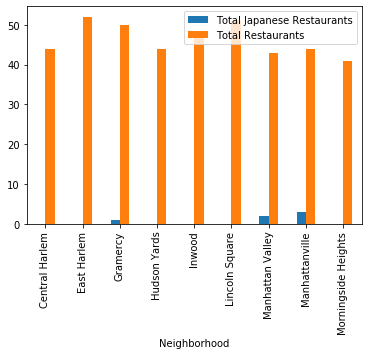

In [110]:
# Cluster 4 has a few neighborhoods where no japanese restaurants
import matplotlib.pyplot as plt

df_cluster4.plot(x='Neighborhood', y=['Total Japanese Restaurants','Total Restaurants'], kind='bar')

plt.show()